We will now load epw files as you did in the previous exercise

In [10]:
import numpy as np
import matplotlib.pyplot as plt
#from numba import jit, vectorize, float64
import math
import pandas as pd
import math
import pandas as pd

import matplotlib.patches as mpatches

# Set date and location
start_date = pd.Timestamp(year=1995, month=7, day=15, hour=8, minute=0, tz='UTC')
latitude = 51.92
longitude = 4.48
altitude = 0

# Set wall tilt and azimuth angles
beta = 90  # wall facing south
azimuth = 180  # south

# Set ground albedo
albedo = 0.2  # typical value for urban surfaces

# Initialize a list to store the total solar radiation for each hour
total_solar_radiation_list = []

epw_header = ['year', 'month', 'day', 'hour', 'minute', 'u_flag', 'Dry bulb T [C]', 'Dew point T [C]',
              'Rel Humidity [%]', 'Atm pressure [Pa]', 'GHIe [Wh/m2]', 'DNIe [Wh/m2]', 'Infrared horiz rad [Wh/m2]',
              'GHI [Wh/m2]', 'DNI [Wh/m2]', 'DHI [Wh/m2]', 'GHE [lx]', 'DNE [lx]', 'DHE [lx]', 'Zenith lum [cd/m2]',
              'Wind direction [deg]', 'Wind speed [m/s]', 'Total sky cover', 'Opaque sky cover', 'Visibility [km]',
              'Ceiling height [m]', 'Present wea observation', 'Present wea codes', 'Precipitable water [mm]',
              'Aerosol optical depth', 'Snow depth [cm]', 'Days since last snow', 'Albedo',
              'Liquid precipitation depth [mm]',
              'Liquid precipitation quantity [hr]']

def read_epw(fn, year=None, printcoord=False):
    """
    Reads an EPW format climate file and saves it as a DataFrame. The first year found in the file is assigned to all data.
    :param fn: file name string
    :return: pandas DataFrame with header and datetime index, [lat [+N], lon [+E], tz [+E], altitude]
    """
    with open(fn) as f:
        line = f.readline()
        print(line)

    lat = float(line.split(',')[6])
    lon = float(line.split(',')[7])
    tz = float(line.split(',')[8])
    alt = float(line.split(',')[9])

    epw = pd.read_csv(fn, skiprows=8, header=None, names=epw_header, na_values=[999999999])
    epw['hour'] = epw['hour'] - 1
    if year is not None:
        epw['year'] = year
    else:
        epw['year'] = epw['year'][0]
    epw.index = pd.to_datetime(epw[['year', 'month', 'day', 'hour']])
    epw = epw.iloc[:, 5:]

    if printcoord:
        return epw, lat, lon, tz, alt
    else:
        return epw

# Upload the weather file, we are skipping the first 8 rows that contain metadata
#epw = read_epw('EPW-MEGA/IWEC/NLD_Amsterdam.062400_IWEC.epw')
#epw=read_epw('EPW-MEGA/CCWeaGenerator/NLD_AMSTERDAM_HadCM3-A2-2080.epw')
epw=read_epw('EPW-MEGA/Historical/Rotterdam-ISD063440-2020.epw')

#initialise variables
total_gh= []
tdb_list=[]
rh_list=[]
wind_list=[]


<class 'FileNotFoundError'>: [Errno 44] No such file or directory: 'EPW-MEGA/Historical/Rotterdam-ISD063440-2020.epw'

Now we will calculate the list of weather variables for the UTCI calculation

In [3]:

# Loop through each hour from 8am to 8pm on July 15th

for hour in range(7, 20):
    # Set the date and time for this hour
    date = pd.Timestamp(year=2020, month=8, day=10, hour=hour)

    # Extract GHI, DNI, and DHI from the epw dataframe for the specific date and time
    ghi = epw.loc[date, 'GHI [Wh/m2]']
    dni = epw.loc[date, 'DNI [Wh/m2]']
    dhi = epw.loc[date, 'DHI [Wh/m2]']

    # Calculate the incident solar radiation on the wall
    I = dni * math.cos(math.radians(beta)) * math.cos(math.radians(azimuth)) + dhi * math.sin(math.radians(beta))

    # Calculate the reflected solar radiation
    if hour <= 17:
        R = 0.2  # ground reflectance
        dni_reflected = dni * R * (1 - math.cos(math.radians(beta))) / 2
        dhi_reflected = dhi * R * math.sin(math.radians(beta))
        Ir = dni_reflected + dhi_reflected
    else:
        Ir = 0

    # Calculate the total solar radiation on the wall for this hour
    I_total = I + Ir

    # Add the total solar radiation to the list
    total_solar_radiation_list.append(I_total)
    # Extract dry bulb temperature and relative humidity from the epw dataframe for the specific date and time
    tdb = epw.loc[date, 'Dry bulb T [C]']
    rh = epw.loc[date, 'Rel Humidity [%]']
    wind=epw.loc[date, 'Wind speed [m/s]']

    # Do something with the dry bulb temperature and relative humidity for this hour
    # For example, add them to lists
    tdb_list.append(tdb)
    rh_list.append(rh)
    wind_list.append(wind)


<class 'NameError'>: name 'pd' is not defined

for the calculation of the UTCI we will refer to the pythermalcomfort library
Please cite us if you use this package: Tartarini, F., Schiavon, S., 2020. pythermalcomfort: A Python package for thermal comfort research. 
SoftwareX 12, 100578. https://doi.org/10.1016/j.softx.2020.100578

In [4]:

def units_converter(from_units="ip", **kwargs):
    """Converts IP values to SI units.

    Parameters
    ----------
    from_units: str
        specify system to convert from
    **kwargs : [t, v]

    Returns
    -------
    converted values in SI units
    """
    results = list()
    if from_units == "ip":
        for key, value in kwargs.items():
            if "tmp" in key or key == "tr" or key == "tdb":
                results.append((value - 32) * 5 / 9)
            if key in ["v", "vr", "vel"]:
                results.append(value / 3.281)
            if key == "area":
                results.append(value / 10.764)
            if key == "pressure":
                results.append(value * 101325)

    elif from_units == "si":
        for key, value in kwargs.items():
            if "tmp" in key or key == "tr" or key == "tdb":
                results.append((value * 9 / 5) + 32)
            if key in ["v", "vr", "vel"]:
                results.append(value * 3.281)
            if key == "area":
                results.append(value * 10.764)
            if key == "pressure":
                results.append(value / 101325)

    return results

def valid_range(x, valid):
    """Filter values based on a valid range."""
    return np.where((x >= valid[0]) & (x <= valid[1]), x, np.nan)
def utci_optimized(tdb, v, tr):
    def exponential(t_db):
        g = [
            -2836.5744,
            -6028.076559,
            19.54263612,
            -0.02737830188,
            0.000016261698,
            (7.0229056 * np.power(10.0, -10)),
            (-1.8680009 * np.power(10.0, -13)),
        ]
        tk = t_db + 273.15  # air temp in K
        es = 2.7150305 * np.log1p(tk)
        for count, i in enumerate(g):
            es = es + (i * np.power(tk, count - 2))
        es = np.exp(es) * 0.01  # convert Pa to hPa
        return es

    eh_pa = exponential(tdb) * (rh / 100.0)
    delta_t_tr = tr - tdb
    pa = eh_pa / 10.0  # convert vapour pressure to kPa
    delta_t_tr = tr - tdb
    return (
        tdb
        + 0.607562052
        + (-0.0227712343) * tdb
        + (8.06470249 * (10 ** (-4))) * tdb * tdb
        + (-1.54271372 * (10 ** (-4))) * tdb * tdb * tdb
        + (-3.24651735 * (10 ** (-6))) * tdb * tdb * tdb * tdb
        + (7.32602852 * (10 ** (-8))) * tdb * tdb * tdb * tdb * tdb
        + (1.35959073 * (10 ** (-9))) * tdb * tdb * tdb * tdb * tdb * tdb
        + (-2.25836520) * v
        + 0.0880326035 * tdb * v
        + 0.00216844454 * tdb * tdb * v
        + (-1.53347087 * (10 ** (-5))) * tdb * tdb * tdb * v
        + (-5.72983704 * (10 ** (-7))) * tdb * tdb * tdb * tdb * v
        + (-2.55090145 * (10 ** (-9))) * tdb * tdb * tdb * tdb * tdb * v
        + (-0.751269505) * v * v
        + (-0.00408350271) * tdb * v * v
        + (-5.21670675 * (10 ** (-5))) * tdb * tdb * v * v
        + (1.94544667 * (10 ** (-6))) * tdb * tdb * tdb * v * v
        + (1.14099531 * (10 ** (-8))) * tdb * tdb * tdb * tdb * v * v
        + 0.158137256 * v * v * v
        + (-6.57263143 * (10 ** (-5))) * tdb * v * v * v
        + (2.22697524 * (10 ** (-7))) * tdb * tdb * v * v * v
        + (-4.16117031 * (10 ** (-8))) * tdb * tdb * tdb * v * v * v
        + (-0.0127762753) * v * v * v * v
        + (9.66891875 * (10 ** (-6))) * tdb * v * v * v * v
        + (2.52785852 * (10 ** (-9))) * tdb * tdb * v * v * v * v
        + (4.56306672 * (10 ** (-4))) * v * v * v * v * v
        + (-1.74202546 * (10 ** (-7))) * tdb * v * v * v * v * v
        + (-5.91491269 * (10 ** (-6))) * v * v * v * v * v * v
        + 0.398374029 * delta_t_tr
        + (1.83945314 * (10 ** (-4))) * tdb * delta_t_tr
        + (-1.73754510 * (10 ** (-4))) * tdb * tdb * delta_t_tr
        + (-7.60781159 * (10 ** (-7))) * tdb * tdb * tdb * delta_t_tr
        + (3.77830287 * (10 ** (-8))) * tdb * tdb * tdb * tdb * delta_t_tr
        + (5.43079673 * (10 ** (-10))) * tdb * tdb * tdb * tdb * tdb * delta_t_tr
        + (-0.0200518269) * v * delta_t_tr
        + (8.92859837 * (10 ** (-4))) * tdb * v * delta_t_tr
        + (3.45433048 * (10 ** (-6))) * tdb * tdb * v * delta_t_tr
        + (-3.77925774 * (10 ** (-7))) * tdb * tdb * tdb * v * delta_t_tr
        + (-1.69699377 * (10 ** (-9))) * tdb * tdb * tdb * tdb * v * delta_t_tr
        + (1.69992415 * (10 ** (-4))) * v * v * delta_t_tr
        + (-4.99204314 * (10 ** (-5))) * tdb * v * v * delta_t_tr
        + (2.47417178 * (10 ** (-7))) * tdb * tdb * v * v * delta_t_tr
        + (1.07596466 * (10 ** (-8))) * tdb * tdb * tdb * v * v * delta_t_tr
        + (8.49242932 * (10 ** (-5))) * v * v * v * delta_t_tr
        + (1.35191328 * (10 ** (-6))) * tdb * v * v * v * delta_t_tr
        + (-6.21531254 * (10 ** (-9))) * tdb * tdb * v * v * v * delta_t_tr
        + (-4.99410301 * (10 ** (-6))) * v * v * v * v * delta_t_tr
        + (-1.89489258 * (10 ** (-8))) * tdb * v * v * v * v * delta_t_tr
        + (8.15300114 * (10 ** (-8))) * v * v * v * v * v * delta_t_tr
        + (7.55043090 * (10 ** (-4))) * delta_t_tr * delta_t_tr
        + (-5.65095215 * (10 ** (-5))) * tdb * delta_t_tr * delta_t_tr
        + (-4.52166564 * (10 ** (-7))) * tdb * tdb * delta_t_tr * delta_t_tr
        + (2.46688878 * (10 ** (-8))) * tdb * tdb * tdb * delta_t_tr * delta_t_tr
        + (2.42674348 * (10 ** (-10))) * tdb * tdb * tdb * tdb * delta_t_tr * delta_t_tr
        + (1.54547250 * (10 ** (-4))) * v * delta_t_tr * delta_t_tr
        + (5.24110970 * (10 ** (-6))) * tdb * v * delta_t_tr * delta_t_tr
        + (-8.75874982 * (10 ** (-8))) * tdb * tdb * v * delta_t_tr * delta_t_tr
        + (-1.50743064 * (10 ** (-9))) * tdb * tdb * tdb * v * delta_t_tr * delta_t_tr
        + (-1.56236307 * (10 ** (-5))) * v * v * delta_t_tr * delta_t_tr
        + (-1.33895614 * (10 ** (-7))) * tdb * v * v * delta_t_tr * delta_t_tr
        + (2.49709824 * (10 ** (-9))) * tdb * tdb * v * v * delta_t_tr * delta_t_tr
        + (6.51711721 * (10 ** (-7))) * v * v * v * delta_t_tr * delta_t_tr
        + (1.94960053 * (10 ** (-9))) * tdb * v * v * v * delta_t_tr * delta_t_tr
        + (-1.00361113 * (10 ** (-8))) * v * v * v * v * delta_t_tr * delta_t_tr
        + (-1.21206673 * (10 ** (-5))) * delta_t_tr * delta_t_tr * delta_t_tr
        + (-2.18203660 * (10 ** (-7))) * tdb * delta_t_tr * delta_t_tr * delta_t_tr
        + (7.51269482 * (10 ** (-9))) * tdb * tdb * delta_t_tr * delta_t_tr * delta_t_tr
        + (9.79063848 * (10 ** (-11)))
        * tdb
        * tdb
        * tdb
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (1.25006734 * (10 ** (-6))) * v * delta_t_tr * delta_t_tr * delta_t_tr
        + (-1.81584736 * (10 ** (-9))) * tdb * v * delta_t_tr * delta_t_tr * delta_t_tr
        + (-3.52197671 * (10 ** (-10)))
        * tdb
        * tdb
        * v
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (-3.36514630 * (10 ** (-8))) * v * v * delta_t_tr * delta_t_tr * delta_t_tr
        + (1.35908359 * (10 ** (-10)))
        * tdb
        * v
        * v
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (4.17032620 * (10 ** (-10)))
        * v
        * v
        * v
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (-1.30369025 * (10 ** (-9)))
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (4.13908461 * (10 ** (-10)))
        * tdb
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (9.22652254 * (10 ** (-12)))
        * tdb
        * tdb
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (-5.08220384 * (10 ** (-9)))
        * v
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (-2.24730961 * (10 ** (-11)))
        * tdb
        * v
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (1.17139133 * (10 ** (-10)))
        * v
        * v
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (6.62154879 * (10 ** (-10)))
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (4.03863260 * (10 ** (-13)))
        * tdb
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (1.95087203 * (10 ** (-12)))
        * v
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + (-4.73602469 * (10 ** (-12)))
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        + 5.12733497 * pa
        + (-0.312788561) * tdb * pa
        + (-0.0196701861) * tdb * tdb * pa
        + (9.99690870 * (10 ** (-4))) * tdb * tdb * tdb * pa
        + (9.51738512 * (10 ** (-6))) * tdb * tdb * tdb * tdb * pa
        + (-4.66426341 * (10 ** (-7))) * tdb * tdb * tdb * tdb * tdb * pa
        + 0.548050612 * v * pa
        + (-0.00330552823) * tdb * v * pa
        + (-0.00164119440) * tdb * tdb * v * pa
        + (-5.16670694 * (10 ** (-6))) * tdb * tdb * tdb * v * pa
        + (9.52692432 * (10 ** (-7))) * tdb * tdb * tdb * tdb * v * pa
        + (-0.0429223622) * v * v * pa
        + 0.00500845667 * tdb * v * v * pa
        + (1.00601257 * (10 ** (-6))) * tdb * tdb * v * v * pa
        + (-1.81748644 * (10 ** (-6))) * tdb * tdb * tdb * v * v * pa
        + (-1.25813502 * (10 ** (-3))) * v * v * v * pa
        + (-1.79330391 * (10 ** (-4))) * tdb * v * v * v * pa
        + (2.34994441 * (10 ** (-6))) * tdb * tdb * v * v * v * pa
        + (1.29735808 * (10 ** (-4))) * v * v * v * v * pa
        + (1.29064870 * (10 ** (-6))) * tdb * v * v * v * v * pa
        + (-2.28558686 * (10 ** (-6))) * v * v * v * v * v * pa
        + (-0.0369476348) * delta_t_tr * pa
        + 0.00162325322 * tdb * delta_t_tr * pa
        + (-3.14279680 * (10 ** (-5))) * tdb * tdb * delta_t_tr * pa
        + (2.59835559 * (10 ** (-6))) * tdb * tdb * tdb * delta_t_tr * pa
        + (-4.77136523 * (10 ** (-8))) * tdb * tdb * tdb * tdb * delta_t_tr * pa
        + (8.64203390 * (10 ** (-3))) * v * delta_t_tr * pa
        + (-6.87405181 * (10 ** (-4))) * tdb * v * delta_t_tr * pa
        + (-9.13863872 * (10 ** (-6))) * tdb * tdb * v * delta_t_tr * pa
        + (5.15916806 * (10 ** (-7))) * tdb * tdb * tdb * v * delta_t_tr * pa
        + (-3.59217476 * (10 ** (-5))) * v * v * delta_t_tr * pa
        + (3.28696511 * (10 ** (-5))) * tdb * v * v * delta_t_tr * pa
        + (-7.10542454 * (10 ** (-7))) * tdb * tdb * v * v * delta_t_tr * pa
        + (-1.24382300 * (10 ** (-5))) * v * v * v * delta_t_tr * pa
        + (-7.38584400 * (10 ** (-9))) * tdb * v * v * v * delta_t_tr * pa
        + (2.20609296 * (10 ** (-7))) * v * v * v * v * delta_t_tr * pa
        + (-7.32469180 * (10 ** (-4))) * delta_t_tr * delta_t_tr * pa
        + (-1.87381964 * (10 ** (-5))) * tdb * delta_t_tr * delta_t_tr * pa
        + (4.80925239 * (10 ** (-6))) * tdb * tdb * delta_t_tr * delta_t_tr * pa
        + (-8.75492040 * (10 ** (-8))) * tdb * tdb * tdb * delta_t_tr * delta_t_tr * pa
        + (2.77862930 * (10 ** (-5))) * v * delta_t_tr * delta_t_tr * pa
        + (-5.06004592 * (10 ** (-6))) * tdb * v * delta_t_tr * delta_t_tr * pa
        + (1.14325367 * (10 ** (-7))) * tdb * tdb * v * delta_t_tr * delta_t_tr * pa
        + (2.53016723 * (10 ** (-6))) * v * v * delta_t_tr * delta_t_tr * pa
        + (-1.72857035 * (10 ** (-8))) * tdb * v * v * delta_t_tr * delta_t_tr * pa
        + (-3.95079398 * (10 ** (-8))) * v * v * v * delta_t_tr * delta_t_tr * pa
        + (-3.59413173 * (10 ** (-7))) * delta_t_tr * delta_t_tr * delta_t_tr * pa
        + (7.04388046 * (10 ** (-7))) * tdb * delta_t_tr * delta_t_tr * delta_t_tr * pa
        + (-1.89309167 * (10 ** (-8)))
        * tdb
        * tdb
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * pa
        + (-4.79768731 * (10 ** (-7))) * v * delta_t_tr * delta_t_tr * delta_t_tr * pa
        + (7.96079978 * (10 ** (-9)))
        * tdb
        * v
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * pa
        + (1.62897058 * (10 ** (-9)))
        * v
        * v
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * pa
        + (3.94367674 * (10 ** (-8)))
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * pa
        + (-1.18566247 * (10 ** (-9)))
        * tdb
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * pa
        + (3.34678041 * (10 ** (-10)))
        * v
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * pa
        + (-1.15606447 * (10 ** (-10)))
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * pa
        + (-2.80626406) * pa * pa
        + 0.548712484 * tdb * pa * pa
        + (-0.00399428410) * tdb * tdb * pa * pa
        + (-9.54009191 * (10 ** (-4))) * tdb * tdb * tdb * pa * pa
        + (1.93090978 * (10 ** (-5))) * tdb * tdb * tdb * tdb * pa * pa
        + (-0.308806365) * v * pa * pa
        + 0.0116952364 * tdb * v * pa * pa
        + (4.95271903 * (10 ** (-4))) * tdb * tdb * v * pa * pa
        + (-1.90710882 * (10 ** (-5))) * tdb * tdb * tdb * v * pa * pa
        + 0.00210787756 * v * v * pa * pa
        + (-6.98445738 * (10 ** (-4))) * tdb * v * v * pa * pa
        + (2.30109073 * (10 ** (-5))) * tdb * tdb * v * v * pa * pa
        + (4.17856590 * (10 ** (-4))) * v * v * v * pa * pa
        + (-1.27043871 * (10 ** (-5))) * tdb * v * v * v * pa * pa
        + (-3.04620472 * (10 ** (-6))) * v * v * v * v * pa * pa
        + 0.0514507424 * delta_t_tr * pa * pa
        + (-0.00432510997) * tdb * delta_t_tr * pa * pa
        + (8.99281156 * (10 ** (-5))) * tdb * tdb * delta_t_tr * pa * pa
        + (-7.14663943 * (10 ** (-7))) * tdb * tdb * tdb * delta_t_tr * pa * pa
        + (-2.66016305 * (10 ** (-4))) * v * delta_t_tr * pa * pa
        + (2.63789586 * (10 ** (-4))) * tdb * v * delta_t_tr * pa * pa
        + (-7.01199003 * (10 ** (-6))) * tdb * tdb * v * delta_t_tr * pa * pa
        + (-1.06823306 * (10 ** (-4))) * v * v * delta_t_tr * pa * pa
        + (3.61341136 * (10 ** (-6))) * tdb * v * v * delta_t_tr * pa * pa
        + (2.29748967 * (10 ** (-7))) * v * v * v * delta_t_tr * pa * pa
        + (3.04788893 * (10 ** (-4))) * delta_t_tr * delta_t_tr * pa * pa
        + (-6.42070836 * (10 ** (-5))) * tdb * delta_t_tr * delta_t_tr * pa * pa
        + (1.16257971 * (10 ** (-6))) * tdb * tdb * delta_t_tr * delta_t_tr * pa * pa
        + (7.68023384 * (10 ** (-6))) * v * delta_t_tr * delta_t_tr * pa * pa
        + (-5.47446896 * (10 ** (-7))) * tdb * v * delta_t_tr * delta_t_tr * pa * pa
        + (-3.59937910 * (10 ** (-8))) * v * v * delta_t_tr * delta_t_tr * pa * pa
        + (-4.36497725 * (10 ** (-6))) * delta_t_tr * delta_t_tr * delta_t_tr * pa * pa
        + (1.68737969 * (10 ** (-7)))
        * tdb
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * pa
        * pa
        + (2.67489271 * (10 ** (-8)))
        * v
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * pa
        * pa
        + (3.23926897 * (10 ** (-9)))
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * pa
        * pa
        + (-0.0353874123) * pa * pa * pa
        + (-0.221201190) * tdb * pa * pa * pa
        + 0.0155126038 * tdb * tdb * pa * pa * pa
        + (-2.63917279 * (10 ** (-4))) * tdb * tdb * tdb * pa * pa * pa
        + 0.0453433455 * v * pa * pa * pa
        + (-0.00432943862) * tdb * v * pa * pa * pa
        + (1.45389826 * (10 ** (-4))) * tdb * tdb * v * pa * pa * pa
        + (2.17508610 * (10 ** (-4))) * v * v * pa * pa * pa
        + (-6.66724702 * (10 ** (-5))) * tdb * v * v * pa * pa * pa
        + (3.33217140 * (10 ** (-5))) * v * v * v * pa * pa * pa
        + (-0.00226921615) * delta_t_tr * pa * pa * pa
        + (3.80261982 * (10 ** (-4))) * tdb * delta_t_tr * pa * pa * pa
        + (-5.45314314 * (10 ** (-9))) * tdb * tdb * delta_t_tr * pa * pa * pa
        + (-7.96355448 * (10 ** (-4))) * v * delta_t_tr * pa * pa * pa
        + (2.53458034 * (10 ** (-5))) * tdb * v * delta_t_tr * pa * pa * pa
        + (-6.31223658 * (10 ** (-6))) * v * v * delta_t_tr * pa * pa * pa
        + (3.02122035 * (10 ** (-4))) * delta_t_tr * delta_t_tr * pa * pa * pa
        + (-4.77403547 * (10 ** (-6))) * tdb * delta_t_tr * delta_t_tr * pa * pa * pa
        + (1.73825715 * (10 ** (-6))) * v * delta_t_tr * delta_t_tr * pa * pa * pa
        + (-4.09087898 * (10 ** (-7)))
        * delta_t_tr
        * delta_t_tr
        * delta_t_tr
        * pa
        * pa
        * pa
        + 0.614155345 * pa * pa * pa * pa
        + (-0.0616755931) * tdb * pa * pa * pa * pa
        + 0.00133374846 * tdb * tdb * pa * pa * pa * pa
        + 0.00355375387 * v * pa * pa * pa * pa
        + (-5.13027851 * (10 ** (-4))) * tdb * v * pa * pa * pa * pa
        + (1.02449757 * (10 ** (-4))) * v * v * pa * pa * pa * pa
        + (-0.00148526421) * delta_t_tr * pa * pa * pa * pa
        + (-4.11469183 * (10 ** (-5))) * tdb * delta_t_tr * pa * pa * pa * pa
        + (-6.80434415 * (10 ** (-6))) * v * delta_t_tr * pa * pa * pa * pa
        + (-9.77675906 * (10 ** (-6))) * delta_t_tr * delta_t_tr * pa * pa * pa * pa
        + 0.0882773108 * pa * pa * pa * pa * pa
        + (-0.00301859306) * tdb * pa * pa * pa * pa * pa
        + 0.00104452989 * v * pa * pa * pa * pa * pa
        + (2.47090539 * (10 ** (-4))) * delta_t_tr * pa * pa * pa * pa * pa
        + 0.00148348065 * pa * pa * pa * pa * pa * pa
    )
def utci(tdb, tr, v, rh, units="SI", return_stress_category=False, limit_inputs=True):
    tdb = np.array(tdb)
    tr = np.array(tr)
    v = np.array(v)
    rh = np.array(rh)

    if units.lower() == "ip":
        tdb, tr, v = units_converter(tdb=tdb, tr=tr, v=v)

    def exponential(t_db):
        g = [
            -2836.5744,
            -6028.076559,
            19.54263612,
            -0.02737830188,
            0.000016261698,
            (7.0229056 * np.power(10.0, -10)),
            (-1.8680009 * np.power(10.0, -13)),
        ]
        tk = t_db + 273.15  # air temp in K
        es = 2.7150305 * np.log1p(tk)
        for count, i in enumerate(g):
            es = es + (i * np.power(tk, count - 2))
        es = np.exp(es) * 0.01  # convert Pa to hPa
        return es

    eh_pa = exponential(tdb) * (rh / 100.0)
    delta_t_tr = tr - tdb
    pa = eh_pa / 10.0  # convert vapour pressure to kPa

    utci_approx = utci_optimized(tdb, v, tr)

    # Checks that inputs are within the bounds accepted by the model if not return nan
    if limit_inputs:
        tdb_valid = valid_range(tdb, (-50.0, 50.0))
        diff_valid = valid_range(tr - tdb, (-30.0, 70.0))
        v_valid = valid_range(v, (0.5, 17.0))
        all_valid = ~(np.isnan(tdb_valid) | np.isnan(diff_valid) | np.isnan(v_valid))
        utci_approx = np.where(all_valid, utci_approx, np.nan)

    if units.lower() == "ip":
        utci_approx = units_converter(tmp=utci_approx, from_units="si")[0]

    if return_stress_category:
        stress_categories = {
            -40.0: "extreme cold stress",
            -27.0: "very strong cold stress",
            -13.0: "strong cold stress",
            0.0: "moderate cold stress",
            9.0: "slight cold stress",
            26.0: "no thermal stress",
            32.0: "moderate heat stress",
            38.0: "strong heat stress",
            46.0: "very strong heat stress",
            1000.0: "extreme heat stress",
        }

        return {
            "utci": np.round_(utci_approx, 1),
            "stress_category": mapping(utci_approx, stress_categories),
        }
    else:
        return np.round_(utci_approx, 1)



Now we will calculate the radiant temperature and the UTCI 

In [5]:

def radiant_temperature(T_se, tdb, T_sky):
    sigma = 5.67e-8  # Stefan-Boltzmann constant
    num = ((T_se+ 273.15)**4) *1
    Tr = np.sqrt(np.power(num, 4))-273.15
    return Tr

# Example values for a person standing 2m from an infinite wall

wall_distance = 2.0  # meters

U = 0.36 # U-value of wall
alpha = 1 # assume a gray wall - this is the wall solar absorptivity

alpha_long=0.8#long wave absorptivity
h= 25.0 #boundary layer heat transfer coefficient
T_sky=-270.15

# Example solar radiation values per hour for a day in July
#solar_radiation_per_hour = [450, 500, 600, 700, 750, 800, 850, 900, 800, 700, 600, 500, 450]
#tdb_per_hour = [25, 24, 25, 26, 26, 28, 29, 27, 26, 25, 26, 25, 25]

sky = 50.0 #long wave radiation to clear sky in summer


# Calculate the radiant temperature and UTCI for each hour and the DT from comfort threshold
Tr_values = []
UTCI_values = []
T_se_values = []
T_sol_air_values = []
Delta_values = []
Delta_num= []
Normalised_performance=[]



for solar_radiation, tdb, rh, wind in zip(total_solar_radiation_list, tdb_list, rh_list, wind_list):
    T_sol_air = tdb + ((alpha * solar_radiation - alpha_long * sky) / h)
    T_se = T_sol_air
    Tr = T_se
    UTCI = utci(tdb=tdb, tr=Tr, v=wind, rh=rh)
    print(UTCI)
    Comfort_UTCI=26.0 #maximum value
    if UTCI > Comfort_UTCI:
        Delta_UTCI= Comfort_UTCI - (UTCI-Comfort_UTCI)
        Normalised_Delta=Delta_UTCI/Comfort_UTCI
        #print(Normalised_Delta)
    elif UTCI <  9.0:
        Delta = 9.0-UTCI
        Delta_num.append(Delta)
        Delta_UTCI=Comfort_UTCI-Delta
        Normalised_Delta =Delta_UTCI/Comfort_UTCI
    else:
        Normalised_Delta = 1
        Delta_UTCI=0

    T_sol_air_values.append(T_sol_air)
    T_se_values.append(T_se)
    Tr_values.append(Tr)
    UTCI_values.append(UTCI)
    Delta_values.append(Delta_UTCI)
    Normalised_performance.append(Normalised_Delta)



<class 'NameError'>: name 'total_solar_radiation_list' is not defined

Now calculate the Resilience

In [6]:
resilience_area = np.trapz(Normalised_performance,dx=1)

# Alternatively, you can use the Simpson's rule for numerical integration
# area = simps(Delta_values, dx=1)

# Print the calculated area
print("Surface area under the curve: ", resilience_area)



Surface area under the curve:  0.0


Let's now plot our results

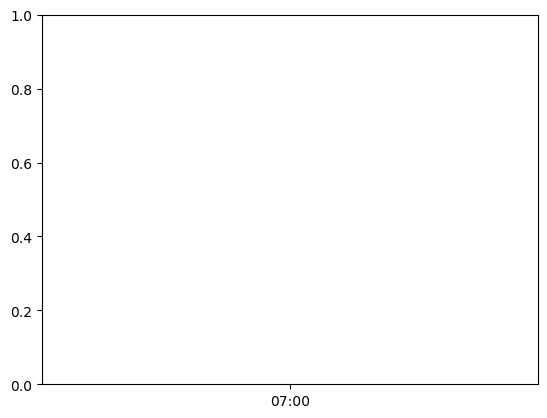

<class 'ValueError'>: x and y must have same first dimension, but have shapes (13,) and (0,)

In [7]:

# Generate the x-axis values as a range from 0 to the length of the Delta_values list
x_values = ["07:00", "09:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00" ]

# Create a list of ones and zeros with the same length as Normalised_performance
y1 = np.ones(len(Normalised_performance))
y2 = np.zeros(len(Normalised_performance))

# Plot the Delta_values data as a line chart
plt.plot(x_values,Normalised_performance, color='black')
# add horizontal line at y=26
plt.axhline(y=1, color='grey', linestyle='--')
plt.axhline(y=0, color='grey', linestyle='--')
# Set the x-axis label and title
plt.xlabel('Time (hours)')

plt.ylim(-0.1, 1.1)  # set the limits of y-axis to be slightly larger than 0 and 1
plt.yticks([0, 1])   # set the y-ticks to be only 0 and 1
# Color the area between the lines
# Set the x-axis label and title
plt.xlabel('Time (hours)')
plt.ylabel('Performance')

resilience_loss= plt.fill_between(x_values, y1, Normalised_performance, where=Normalised_performance < y1, interpolate=True, alpha=0.5, edgecolor='red', facecolor='none', hatch='////')
resilience= plt.fill_between(x_values, y2, Normalised_performance, where=Normalised_performance >= y2, interpolate=True, alpha=0.5, color='grey',  hatch='////')
# Create proxy artists for the legend
red_hatch = mpatches.Patch(facecolor='white', edgecolor='red', hatch='////', label='Resilience Loss')
grey_hatch = mpatches.Patch(facecolor='grey', hatch='////', label='Resilience')

# Add the legend
plt.legend(handles=[red_hatch, grey_hatch])


# Show the chart
plt.show()